After multiple courses on Machine Learning, Neural Networks and Deep Learning through Udemy and Coursera I've been eager to apply my newly found skills to some real-world data. That's when I stumbled upon kaggle.com, a repository of data science datasets and challenges, and decided to find a dataset I could get started on. The data science 'tutorial' challenge on kaggle.com is a dataset on the Titanic Disaster. Trying to predict the survival rate of passengers based on their Age, Sex and other features.

For brevity and readability a lot of the python code I've written to explore this problem has been written inside a lib folder instead of inside this notebook. All the code is available in the AI repo; https://github.com/AlexanderVanEck/artificial-intelligence-case-studies



In [1]:
from titanic.lib.algorithms import *
from titanic.lib.engineering import *
from titanic.lib.libraries import *
from titanic.lib.plotting import *
from titanic.lib.preprocessing import *

Using TensorFlow backend.


The challenge supplies me with a training set and a testing set. The testing set contains passenger data including a column indicating the survival of that passenger. The testing set contains the same kind of passenger data, from different passengers, but without the survival column. The goal is to create a classifier that predicts this value of the survived column for the testing set of passenger given the training set.

## Feature Cleaning

In [2]:
training_dataframe = pd.read_csv('titanic/datasets/train.csv')
testing_dataframe = pd.read_csv('titanic/datasets/test.csv')
training_dataframe.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


For now these five rows give me only few insights into the data. I see that the Cabin column can contain NotANumber (NaN) and that some columns contain words, while others just letters or numbers.

In [3]:
training_dataframe.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Pettersson, Miss. Ellen Natalia",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


There's a few conclusions to draw from the table above; First off Age/Cabin and Embarked do not have values for every row. Second, there's also a few columns, like Name/Ticket and PassengerId, that seem useless at first glance. They could maybe be used to create new features.


## Feature cleaning

In order to clean both the training and testing dataset I'm going to build up a collection of imputation functions. Later I'll execute all the imputation functions on both datasets.


In [4]:
imputation_collector = ImputationCollector()
cleaning_dataframe = training_dataframe.copy()

**Embarked**

There are two missing values for Embarked.

In [5]:
cleaning_dataframe[cleaning_dataframe.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Both entries paid a Fare of 80 pounds for a 1st class ticket (Pclass). A quick look at the average price that was paid from each port should give us the likely departure port.

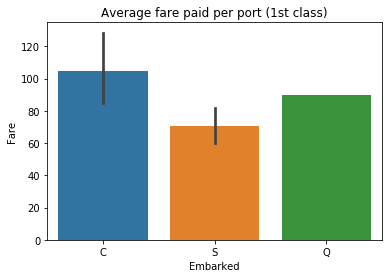

In [6]:
sns.barplot(x='Embarked', y='Fare', data=cleaning_dataframe[cleaning_dataframe.Pclass == 1], estimator=np.mean)
plot.title('Average fare paid per port (1st class)')
plot.show()

With the above plot I'm relatively sure that both these passengers departed from Southampton.

In [7]:
imputation_collector.add_operation(impute_embarked)
cleaning_dataframe = impute_embarked(cleaning_dataframe)

**Fare**

The training data also has 1 missing value in Fare; Since they also left from Southampton I'll fill the records with the average of what passengers paid from that destination in that class.

In [8]:
testing_dataframe[testing_dataframe.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [9]:
imputation_collector.add_operation(impute_fare)
cleaning_dataframe = impute_fare(cleaning_dataframe)

**Age**

Age has quite a few missing values. It would be really easy to just fill the missing values up with the average age of all passengers... However this would completely destroy the age distribution. Age should actually be allocated based on their similarity to other passengers.

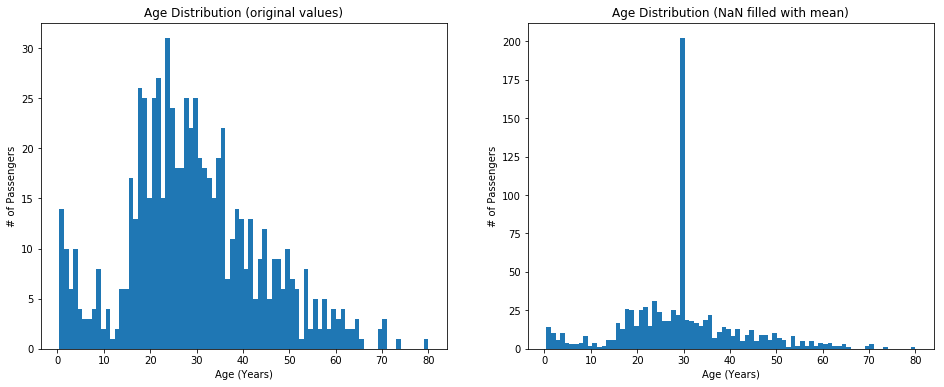

In [10]:
plot.figure(figsize=[16,6])
plot.subplot(121)
plot_age_histogram(cleaning_dataframe[cleaning_dataframe.Age >= 0].Age, 'original values')

plot.subplot(122)
plot_age_histogram(cleaning_dataframe.Age.fillna(cleaning_dataframe.Age.mean()), 'NaN filled with mean')

Clearly that's not the right approach. There's multiple ways to impute. I'll try out a few different ones and choose the one where the distribution remains relatively the same.

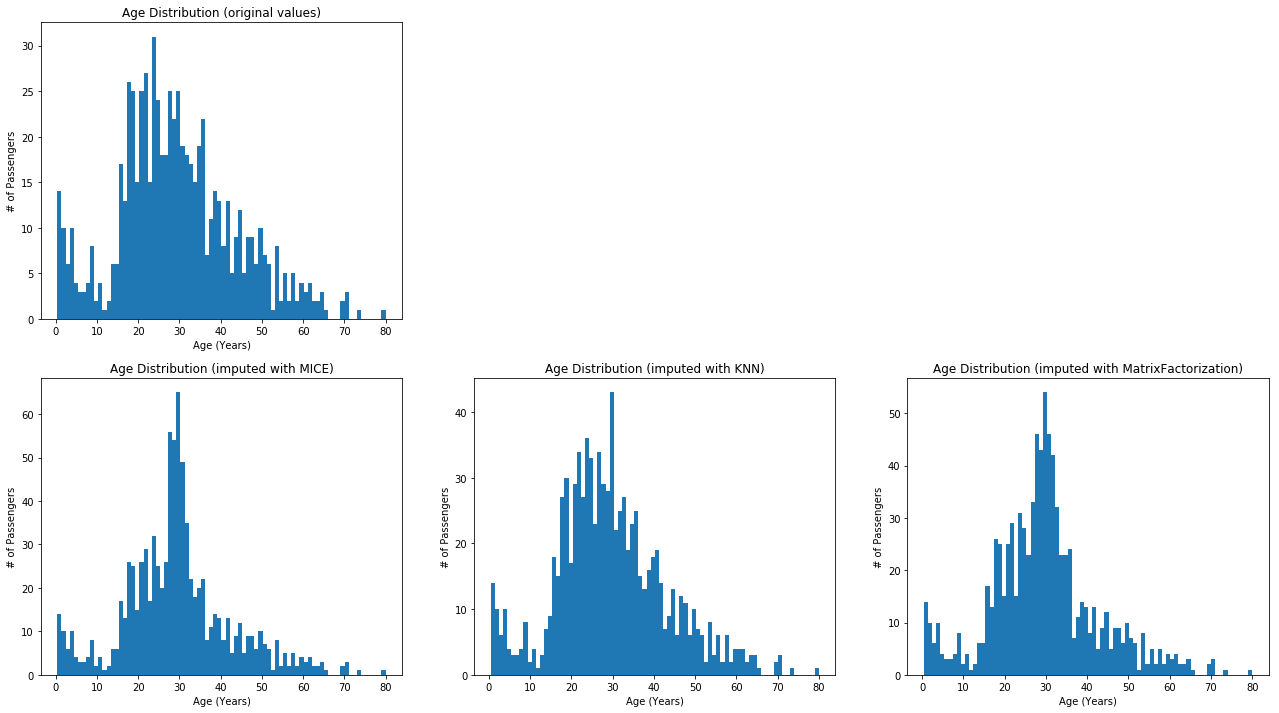

In [11]:
plot.figure(figsize=[22,12])
plot.subplot(231)
plot_age_histogram(cleaning_dataframe[cleaning_dataframe.Age >= 0].Age, 'original values')

plot.subplot(234)
plot_imputation_on_age(MICE, cleaning_dataframe)

plot.subplot(235)
plot_imputation_on_age(KNN, cleaning_dataframe, imputer_kwargs={'k': 5})

plot.subplot(236)
plot_imputation_on_age(MatrixFactorization, cleaning_dataframe)

From the above three imputation strategies I conclude that the KNN (with 5 nearest neighbours) keeps the distribution mostly equal to the training dataset. To me this indicates that it won't introduce significant bias. I'll use KNN to impute Age.

In [12]:
imputation_collector.add_operation(impute_age_with_knn)
cleaning_dataframe = impute_age_with_knn(cleaning_dataframe)

**Cabin**

The Cabin feature has too few values to impute missing ones... But I can use it to generate features on the rows that do have a value for it. For now I'll fill all the NaN rows with a U for 'Unknown'.

In [13]:
imputation_collector.add_operation(impute_cabin)
cleaning_dataframe = impute_cabin(cleaning_dataframe)

## Feature engineering

This is my favorite step. I like to think creatively about what each feature has to teach us and come up with new insights! Then see if it will help the classifiers.
One of the things I like to keep in the back of my mind is that features ideally track only 1 thing. F.e. the Cabin feature tracks the location on the ship both in Deck level and the side of the ship a passenger was on.

In [14]:
cleaning_dataframe.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,U,S
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S
80,81,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,U,S
696,697,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,U,S
693,694,0,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,U,C


A couple of interesting features stick out to me;

**Cabin decks & room numbers**

The Cabin feature consists of a Deck letter and a roomnumber. These can be seperated. The Titanic sank because an iceberg created a hole under the waterlevel on her starboard side. It's reasonable to assume that it was harder to escape the lower decks and starboard cabins than the upper decks on the port side.

**Family**

The SibSp and Parch features are a combination of how Siblings/Spouses and Parents/Children. These give an indication of amount of family members travelling together. I'll combine them into a single feature.

**Name**

Most of the names have a title in them, this could be interesting data for the classifier. However, the title also encodes gender. I think I can extract social status from the title and make sure it only does not also codify gender.

Furthermore there's a few features that seem to have no relation to survivabilty; like the PassengerId or Ticket number. I won't show those to the classifier.


In [15]:
# Create Deck feature
imputation_collector.add_operation(engineer_deck)
cleaning_dataframe = engineer_deck(cleaning_dataframe)
cleaning_dataframe[cleaning_dataframe.Deck != 'U'].sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,35.651334,0,0,113767,50.000,A32,S,A
303,304,1,2,"Keane, Miss. Nora A",female,30.000092,0,0,226593,12.350,E101,Q,E
815,816,0,1,"Fry, Mr. Richard",male,38.999989,0,0,112058,0.000,B102,S,B
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.000000,0,0,PC 17757,227.525,C45,C,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.000000,2,2,PC 17608,262.375,B57 B59 B63 B66,C,B


In [16]:
# Create Port feature
imputation_collector.add_operation(engineer_port)
cleaning_dataframe = engineer_port(cleaning_dataframe)
cleaning_dataframe[cleaning_dataframe.Port != 'U'].sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Port
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.000000,0,0,113786,30.50,C104,S,C,S
209,210,1,1,"Blank, Mr. Henry",male,40.000000,0,0,112277,31.00,A31,C,A,P
712,713,1,1,"Taylor, Mr. Elmer Zebley",male,48.000000,1,0,19996,52.00,C126,S,C,S
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,22.000107,0,1,113505,55.00,E33,S,E,P
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.000000,0,0,348121,7.65,F G63,S,G,P


In [17]:
# Create FamilySize feature
imputation_collector.add_operation(engineer_family_size)
cleaning_dataframe = engineer_family_size(cleaning_dataframe)
cleaning_dataframe.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Port,FamilySize
240,241,0,3,"Zabour, Miss. Thamine",female,14.750077,1,0,2665,14.4542,U,C,U,U,2
56,57,1,2,"Rugg, Miss. Emily",female,21.000000,0,0,C.A. 31026,10.5000,U,S,U,U,1
357,358,0,2,"Funk, Miss. Annie Clemmer",female,38.000000,0,0,237671,13.0000,U,S,U,U,1
503,504,0,3,"Laitinen, Miss. Kristina Sofia",female,37.000000,0,0,4135,9.5875,U,S,U,U,1
58,59,1,2,"West, Miss. Constance Mirium",female,5.000000,1,2,C.A. 34651,27.7500,U,S,U,U,4


**Title**

The Title feature is harder to interpret. It's possible to extract and leave them as is but this won't generalise very well.. Titles that only appear the data once do not provide any extra benefit to the classifier. Categorisation seems in order. Every title that has less than 10 usages is categorised as 'Rare'.

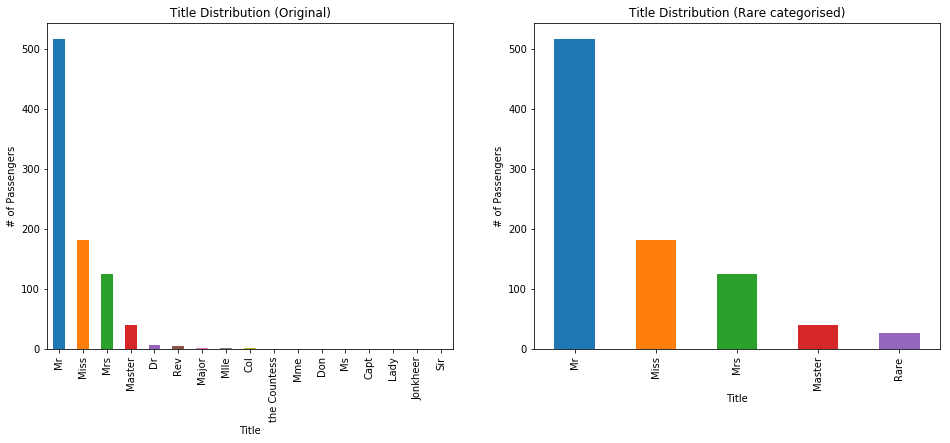

In [18]:
plot.figure(figsize=[16,6])

plot.subplot(121)
imputation_collector.add_operation(engineer_title)
cleaning_dataframe = engineer_title(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Original')

plot.subplot(122)
imputation_collector.add_operation(clean_uncommon_titles)
cleaning_dataframe = clean_uncommon_titles(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Rare categorised')
plot.show()

Moreover, The most common titles are 'Mr', 'Miss', 'Mrs' and 'Master'. These titles don't only encode social status but also gender. After some thought I've decided that I do not want a feature to track 2 variables so I'm going to normalise these titles. 
'Master' - typically indicating young boys.
'Miss' - a woman who has not been married.
'Mrs' - a woman who is married.
'Mr' - a man, married or not.

Therefore I propose the following;
* Master's who are under 18 are only called such because they are young. I'll remove their title.
* Masters above 18 hold some kind of rank. I'll categorise them as 'rank'
* Miss's who are under 18 are called miss because they are women and nothing else. I'll remove their title.
* Miss's who are above 18 have not been married, this makes them 'single'.
* Mrs. are woman who have been married, this makes them 'married'.

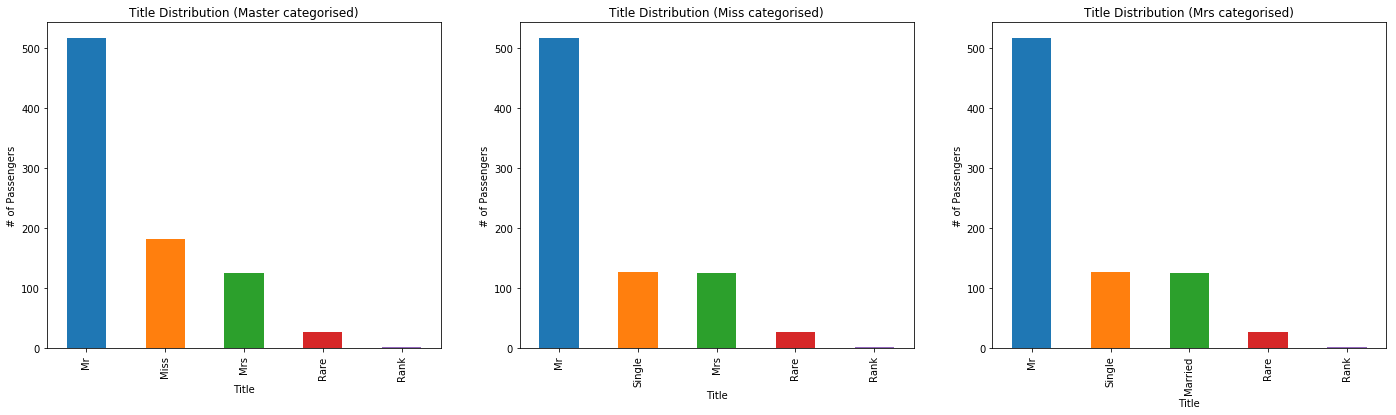

In [19]:
plot.figure(figsize=[24,6])

plot.subplot(131)
imputation_collector.add_operation(clean_master_title)
cleaning_dataframe = clean_master_title(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Master categorised')

plot.subplot(132)
imputation_collector.add_operation(clean_miss_title)
cleaning_dataframe = clean_miss_title(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Miss categorised')

plot.subplot(133)
imputation_collector.add_operation(clean_mrs_title)
cleaning_dataframe = clean_mrs_title(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Mrs categorised')

plot.show()

The 'Mr' title is a bit harder, since a married man is still a 'Mr'. For this I'm going to look at a few other statistics. (https://www.theguardian.com/news/datablog/2010/feb/11/marriage-rates-uk-data & http://www.edwardianpromenade.com/people/the-marriage-age-1896-1908/)

These sources tell me the rate of marriage among men was 53% and the average age of marriage was 27 around the turn of the century.

* When a Mr. is under 18 they are an adolescant and should lose their title.
* When a Mr. is under 27 they are 'single'.
* When a Mr. is over 27; flip a coin (53%) whether they are 'single' or 'married'. This means the distribution will differ somewhat, but probably not significantly.

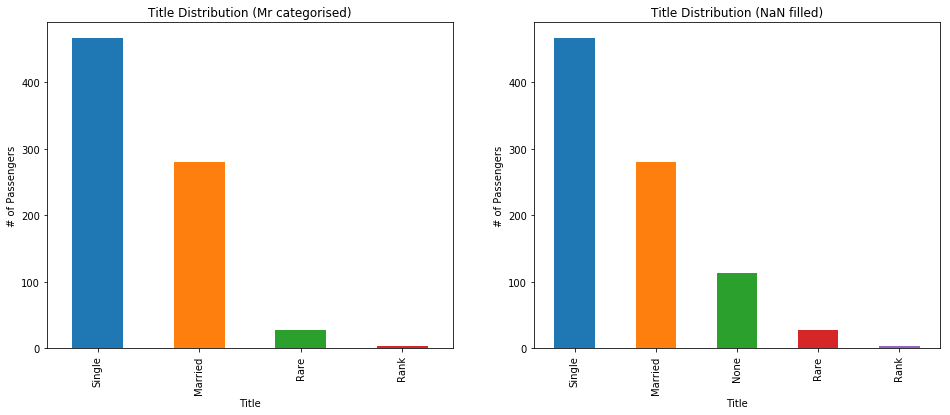

In [20]:
plot.figure(figsize=[16,6])

plot.subplot(121)
imputation_collector.add_operation(clean_mr_title)
cleaning_dataframe = clean_mr_title(cleaning_dataframe)
plot_title(cleaning_dataframe, 'Mr categorised')

plot.subplot(122)
imputation_collector.add_operation(impute_titles)
cleaning_dataframe = impute_titles(cleaning_dataframe)
plot_title(cleaning_dataframe, 'NaN filled')

plot.show()



## Feature preparation
After engineering the data it's time to prepare it for the classifier! Do away with categorical data and convert it into numbers.

If we assign f.e. the Deck feature into 'random' ordered 0..9 values this would mean that Deck T could have more weight than Deck G. Even though it should be the other way around. So then we could one-hot encode them. Now all decks are exactly the same weight, but this is also not true. Deck A has less weight than Deck B and so on. Deck T has the most amount of weight because it was closest to the lifeboats and an Unkown Deck (U) has no weight at all. My question is as follows; If I label encode the decks according to their order of importance am I introducing unnecessary bias into this feature? and how does this work with continous features like Age? This is something I'm still trying to figure out, does the feature have to be as un-biased as possible so the classifier can itself find out which Decks are more important?

Furthermore, Deck and Pclass are also related to eachother since a higher Pclass means the passenger would be more on top of the ship where the lifeboats are. Doesn't this create bias to where a person could have been on the ship during the crash by providing 2 variables instead of 1 for decks the passenger could've been on?

From testing with this dataset it does not seem to matter much for the accuracy of the classifier, therefore I'll use order of importance;
* Title in order of importance (Rare (4), Rank (3), Married (2), Single (1), None (0))
* Port in order of importance (Starboard (2), Portside (1), Unkown (0))
* Deck in order of importance (G (8), F (7), E (6), D (5), C (4), B (3), A (2), T (1), U (0))
* Embarked one-hot encoded since every feature is equal and there's no releation between them.
* Gender one-hot encoded since there's only 2 classes.


In [21]:
imputation_collector.add_operation(prepare_features_on_importance)
cleaning_dataframe = prepare_features_on_importance(cleaning_dataframe)

imputation_collector.add_operation(prepare_dummies_embarked_and_gender)
cleaning_dataframe = prepare_dummies_embarked_and_gender(cleaning_dataframe)

imputation_collector.add_operation(prepare_age_and_fare_buckets)
cleaning_dataframe = prepare_age_and_fare_buckets(cleaning_dataframe)

cleaning_dataframe.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Deck,Port,FamilySize,Title,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,0,U,0,0,2,1,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,1,0,PC 17599,3,C85,4,2,2,2,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,1,U,0,0,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,1,0,113803,3,C123,4,2,2,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",2,0,0,373450,1,U,0,0,1,1,1,0,1


## Feature space

With the prepared data sorted I like to visualise the data in a couple ways and run a few default steps before I run the data through a classifier.

In [22]:
# impute training and testing data with collected imputations
training_dataframe = imputation_collector.transform(training_dataframe)
testing_dataframe = imputation_collector.transform(testing_dataframe)

In [23]:
# Convert DataFrames to numpy arrays
independent_variables = training_dataframe.columns.drop(['Survived', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'])
X = training_dataframe.drop(['Survived', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1).values
y = training_dataframe['Survived'].values
X_test = testing_dataframe.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1).values

In [24]:
# Scale the data
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)
X_test = standard_scaler.transform(X_test)

/Users/Alexander/Virtualenvs/ai/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


What does good accuracy look like? What percentage is there to beat?

In [25]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X, y)
print(f'Accuracy when predicting most-frequent class; {dummy_classifier.score(X, y)}')

dummy_classifier = DummyClassifier(strategy="uniform")
dummy_classifier.fit(X, y)
print(f'Accuracy when predicting random class; {dummy_classifier.score(X, y)}')

Accuracy when predicting most-frequent class; 0.6161616161616161
Accuracy when predicting random class; 0.4882154882154882


How many features explain most of the variance in the data? From the PCA analysis below we can see that there are 4 features that explain almost 60% of the variance in regards to the output. 

In [26]:
pca = PCA(n_components=None)
pca.fit_transform(X)
pca.transform(X_test)
pd.DataFrame(pca.explained_variance_ratio_ * 100)

,0
0,31.480453
1,17.126501
2,15.393651
3,10.484687
4,8.114816
5,5.872380
6,4.817549
7,3.736451
8,1.660839
9,1.312674


Then I like to run a TSNE to reduce the dimensionalty back to 2 dimensions so it can be visualised in a standard plot. I run these with difference perplexity to see if at any point the figure stabilises and shows a clear seperation. A clear seperation tells me that there's a possiblity of a classifier recognising this structure in multi-dimensions.

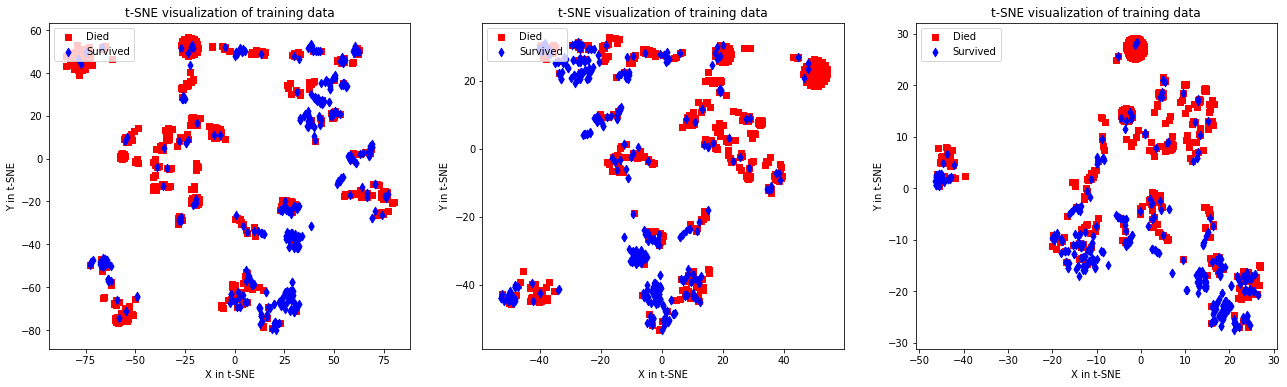

In [27]:
plot.figure(figsize=[22,6])

plot.subplot(131)
tsne = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=5000)
plot_tsne(tsne.fit_transform(X), y)

plot.subplot(132)
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
plot_tsne(tsne.fit_transform(X), y)

plot.subplot(133)
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
plot_tsne(tsne.fit_transform(X), y)

plot.show()

From the plot above it seems clear that a classifier should be able to beat 61%. So now I'm going to take all classifiers from sklearn and fit them to the data, and compare them to a holdout set (from the training set).

In [28]:
classifier_comparison = compare_classifiers(X, y)
classifier_comparison

,Name,Train Accuracy Mean,Dev Accuracy Mean,Dev Accuracy 3*STD,Time
21,XGBClassifier,0.865730,0.810448,0.050510,0.021452
3,GradientBoostingClassifier,0.878277,0.810075,0.044902,0.083154
15,NuSVC,0.831835,0.809328,0.050174,0.035573
14,SVC,0.844007,0.808955,0.044439,0.031923
5,GaussianProcessClassifier,0.896255,0.808582,0.042197,0.098099
13,KNeighborsClassifier,0.853933,0.806716,0.073370,0.000701
4,RandomForestClassifier,0.915543,0.806716,0.049507,0.015291
2,ExtraTreesClassifier,0.921723,0.804851,0.049571,0.015550
6,LogisticRegressionCV,0.805056,0.800746,0.056903,0.072940
8,RidgeClassifierCV,0.798127,0.796269,0.052552,0.001843


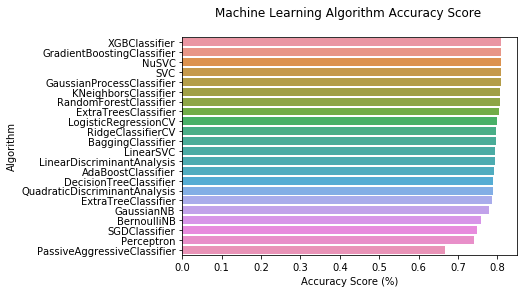

In [29]:
plot_classifier_comparison(classifier_comparison)

Interestingly the GradientBoostingClassifier and XGBClassifier get up to 81% on the dev set!

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier = classifier.fit(X, y)
pd.DataFrame(classifier.feature_importances_, index=independent_variables, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
FamilySize,0.212380
Fare,0.160686
Sex_male,0.150663
Age,0.139297
Pclass,0.096902
Deck,0.076059
Title,0.075868
Port,0.052009
Embarked_S,0.021575
Embarked_Q,0.014560


And it seems clear that FamilySize and Fare, and thus on which deck passengers stayed, are most relevant to these classifiers.

# Conclusion

With this specific feature preparation and without any other feature selection techniques this approach was able to get an accuracy of 81% of the training set. Testing accuracy is verified on kaggle.com and this approach yielded 78% there. Not bad for my first case study ever!

Things I had to learn to complete this challenge;

1. Thinking about distributions and how to impute data correctly.
2. Plotting data to visualise what I'm workin on.
3. TSNE, a very handy tool to consult on dimensionality reduction.

However, I still have a few questions left unanswered...

1. Do features have to be as unbiased as possible? F.e. as explained above with different Decks. Or do I encode the relationships between the decks?
2. What about continuous values (e.g. Age)? I created 4 age 'buckets' in this case study to be less biased towards higher ages but do these 'buckets' have to be as un-biased as possible (one-hot encoded)?
3. How do I deal with double encoded features, F.e. Title also encoding gender even though the title is the same. Doesn't this make the data more biased towards gender?

All in all this has been a fun challenge and I look forward to answering questions, I might post an update when I've learned more!